In [50]:
# Make plots visible in iPython notebook
%matplotlib inline

In [51]:
# Set path to training data
path = "data/"

In [52]:
# Import necessary libraries
from __future__ import division, print_function

import os, json
from glob import glob
import numpy as np
np.set_printoptions(precision=4, linewidth=100)
from matplotlib import pyplot as plt

In [53]:
import utils; reload(utils)
from utils import plots

In [54]:
# Now we'll load, fit and use the VGG model to generate predictions

# Define size of image batches to be processed by VGG model
batch_size = 64
# We could set a number of epochs, 
# or just run the model multiple times 
# so that we can save the weights after each run.
no_of_epochs = 2

# Instantiate VGG model
import vgg16; reload(vgg16)
from vgg16 import Vgg16

In [55]:
vgg = Vgg16()

# Send training and validation batches to the VGG model
batches = vgg.get_batches(path+'train',batch_size=batch_size)
val_batches = vgg.get_batches(path+'valid', batch_size=batch_size)

Found 21997 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [56]:
# Calling 'finetune' allows us to modify the model to train 
# based on modified data categories (cat or dog)

vgg.finetune(batches)


In [57]:
# Now, fit model parameters using the training data and then report
# accuracy measurement using the validation set

latest_weights_filename = None
for epoch in range(no_of_epochs):
    print ("Running epoch: %d " % epoch)  
    vgg.fit(batches, val_batches, nb_epoch=1)
    # Save weights for each epoch
    latest_weights_filename = 'ft%d.h5' % epoch
    vgg.model.save_weights(path+"results/"+latest_weights_filename)
print ("Completed %s fit operations" % no_of_epochs) 

Running epoch: 0 
Epoch 1/1
21997/21997 [==============================] - 581s - loss: 0.1189 - acc: 0.9690 - val_loss: 0.0413 - val_acc: 0.9875
Running epoch: 1 
Epoch 1/1
21997/21997 [==============================] - 582s - loss: 0.1021 - acc: 0.9766 - val_loss: 0.0572 - val_acc: 0.9860
Completed 2 fit operations


In [58]:
vgg.model.load_weights(path+"results/ft0.h5")
# Load test dataset images and make predictions
batches, preds = vgg.test(path+'test', batch_size=batch_size*2)

Found 12498 images belonging to 1 classes.


In [59]:
# What format are our predictions in, and for which files?
print (preds[:5])
filenames = batches.filenames
print (filenames[:5])

[[  1.0000e+00   2.7740e-10]
 [  6.0744e-01   3.9256e-01]
 [  1.0000e+00   2.0014e-06]
 [  1.0000e+00   1.6119e-12]
 [  7.1288e-09   1.0000e+00]]
['unknown/9292.jpg', 'unknown/12026.jpg', 'unknown/9688.jpg', 'unknown/4392.jpg', 'unknown/779.jpg']


In [60]:
from shutil import copyfile
from utils import *
import sys

# Let's save our predictions for future use
save_array(path+'results/test_preds.dat', preds)
save_array(path+'results/filenames.dat', filenames)

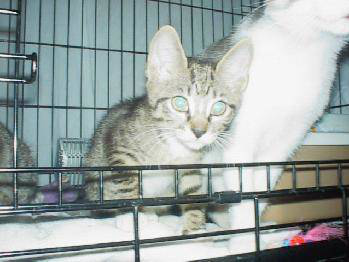

In [61]:
# Let's confirm which order predictions are in
from PIL import Image
Image.open(path+'test/unknown/9292.jpg')

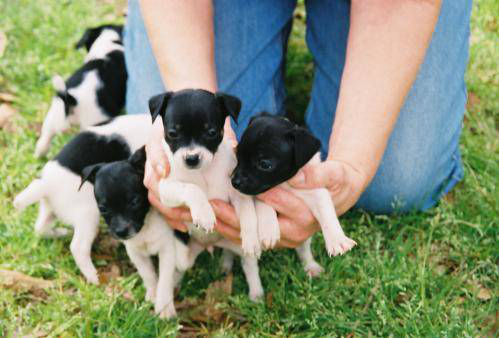

In [62]:
# First image is a cat, so it appears predictions are in format:
# [cat, dog]
Image.open(path+'test/unknown/779.jpg')

In [63]:
# Yes, we can confirm this is the case.

# Now, let's look at performance on the validation set 
vgg.model.load_weights(path+'results/ft0.h5')

In [66]:
val_batches, probs = vgg.test(path+'valid', batch_size = batch_size)

Found 2000 images belonging to 2 classes.


In [65]:
filenames = val_batches.filenames
expected_labels = val_batches.classes

# Round predictions to 0 or 1 to generate labels
our_predictions = probs[:,0]
our_labels = np.round(1-our_predictions)

In [67]:
# Generating a confusion matrix allows us to get 
# a quick sense of the performance of our model
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(expected_labels, our_labels)

[[993   7]
 [ 11 989]]


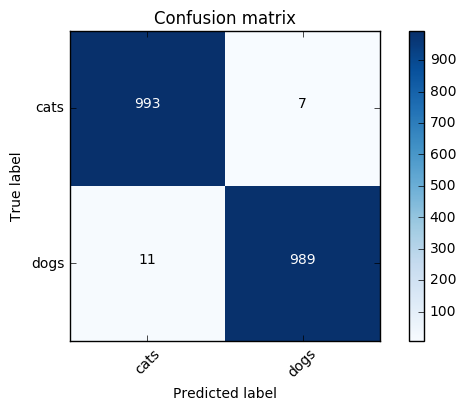

In [68]:
plot_confusion_matrix(cm, val_batches.class_indices)

In [69]:
# Get prediction data into Kaggle-submittable form
preds = load_array(path+'results/test_preds.dat')
filenames = load_array(path+'results/filenames.dat')

In [70]:
# We want to make our predictions a little less confident
# So we don't get penalized by logloss
isdog = preds[:,1]
isdog = isdog.clip(min=0.0125, max=0.9875)

In [71]:
# Extract image id numbers from filenames in test directory
filenames = batches.filenames
ids = np.array([int(f[8:f.find('.')]) for f in filenames])

In [72]:
# Join columns into an array of [image id, prediction-isDog]
subm = np.stack([ids,isdog], axis=1)
subm[:5]

array([[  9.2920e+03,   1.2500e-02],
       [  1.2026e+04,   3.9256e-01],
       [  9.6880e+03,   1.2500e-02],
       [  4.3920e+03,   1.2500e-02],
       [  7.7900e+02,   9.8750e-01]])

In [73]:
submission_file_name = 'submission1.csv'
np.savetxt(path+'results/'+submission_file_name, subm, fmt='%d,%.5f', header='id,label', comments='')

In [74]:
from IPython.display import FileLink
FileLink(path+'results/'+submission_file_name)

/home/ubuntu/fastai/courses/deeplearning1/nbs/data/results/submission1.csv